# Airline Customer Segmentation Based on LRFMC Model
***

Customer segmentation is defined as the process where customers of an enterprise are divided into groups based on their purchasing behavior and characteristics. Segmentation could be based on customer's demographic, psychographic, geographic, and behavioural attributes. Behavioural attributes include past purchasing pattern such as latest purchase and purchase frequency. The objective of this project is the categorization of customer records into several groups in the aviation Business-to-Customer (B2C) context, using clustering analysis. This is accomplished by first using the Length, Recency, Frequency, Monetary (LRFM) customer lifetime value model, which scores customers according to four attributes; the relationship length with the company (L), recency of latest transaction (R), purchasing frequency (F), monetary value of customer (M), and cabin or passenger space (C). Then, the poject implement clustering model using the k-means++ algorithm, where customer records are segmented based on their respective LRFMC values. Also, the proposed model is integrated with a hyperparameter tuning phase, where the selection of the number of clusters is performed by employing Elbow Method. Finally, the clustering results are visualized and discussed. Through the customer segmentation, high value customer could be distinguished from valueless customer. 

The dataset used by the project will be attached in the same folder with this file.

**Objective :**

* Categorize customers into several groups based on LRFMC customer lifetime value model. 
* Create recommended actionable insight and approach to the customers.
* Learn about big data clustering.

### Import Library

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Load Dataset

In [3]:
flight = pd.read_csv('1659264665216-flight.csv')
flight.head()

,MEMBER_NO,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,...,SUM_YR_2,SEG_KM_SUM,LAST_FLIGHT_DATE,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
0,54993,11/2/2006,12/24/2008,Male,6,.,beijing,CN,31.0,3/31/2014,...,234188.0,580717,3/31/2014,1,3.483254,18,34,0.961639,619760,50
1,28065,2/19/2007,8/3/2007,Male,6,NaN,beijing,CN,42.0,3/31/2014,...,167434.0,293678,3/25/2014,7,5.194245,17,29,1.252314,415768,33
2,55106,2/1/2007,8/30/2007,Male,6,.,beijing,CN,40.0,3/31/2014,...,164982.0,283712,3/21/2014,11,5.298507,18,20,1.254676,406361,26
3,21189,8/22/2008,8/23/2008,Male,5,Los Angeles,CA,US,64.0,3/31/2014,...,125500.0,281336,12/26/2013,97,27.863636,73,11,1.090870,372204,12
4,39546,4/10/2009,4/15/2009,Male,6,guiyang,guizhou,CN,48.0,3/31/2014,...,130702.0,309928,3/27/2014,5,4.788079,47,27,0.970658,338813,39


In [4]:
#lower all columns' name
flight.columns = flight.columns.str.lower()

## 1. Data Understanding and Data Cleaning

### 1.1. General Information

In [4]:
#shape of dataset
flight.shape

(62988, 23)

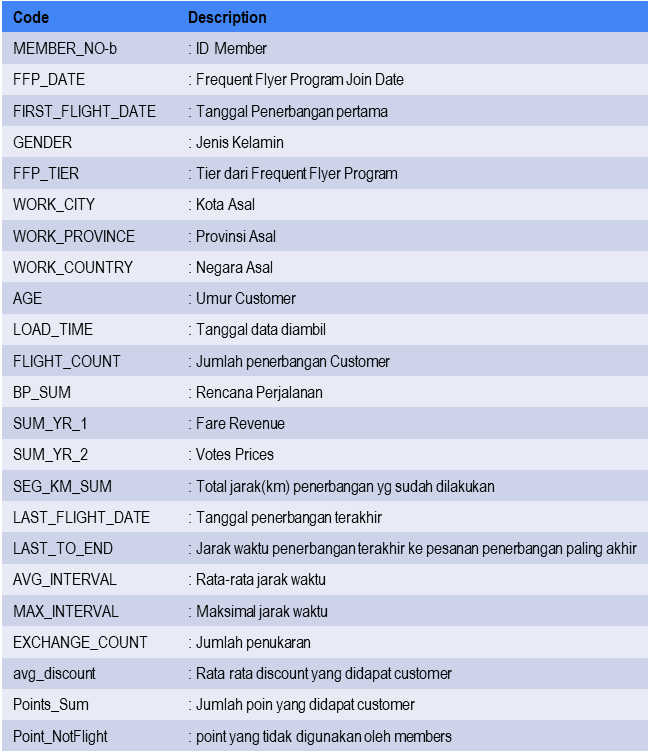

In [5]:
#get data type and null values for each column
flight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62988 entries, 0 to 62987
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   member_no          62988 non-null  int64  
 1   ffp_date           62988 non-null  object 
 2   first_flight_date  62988 non-null  object 
 3   gender             62985 non-null  object 
 4   ffp_tier           62988 non-null  int64  
 5   work_city          60719 non-null  object 
 6   work_province      59740 non-null  object 
 7   work_country       62962 non-null  object 
 8   age                62568 non-null  float64
 9   load_time          62988 non-null  object 
 10  flight_count       62988 non-null  int64  
 11  bp_sum             62988 non-null  int64  
 12  sum_yr_1           62437 non-null  float64
 13  sum_yr_2           62850 non-null  float64
 14  seg_km_sum         62988 non-null  int64  
 15  last_flight_date   62988 non-null  object 
 16  last_to_end        629

Several columns have null values: `gender`, `work_city`, `work_province`, `work_country`, `age`, `sum_yr_1`, and `sum_yr_2`.

Several columns need to be adjusted by their proper data types: 
* `ffp_date`, `first_flight_date`, `load_time`, `last_flight_date` --> date format

### 1.2. Convert Columns' Data Type

In [5]:
#convert some columns' data type into datetime
flight['ffp_date'] = pd.to_datetime(flight['ffp_date'])
flight['first_flight_date'] = pd.to_datetime(flight['first_flight_date'])
flight['load_time'] = pd.to_datetime(flight['load_time'])

There is an error when we try to convert `last_flight_date` column and turns out there is several data that have different datetime format and completely wrong date.

Since `2014/2/29  0:00:00` does not exist in calendar (2014 is not leap year), so we change it to the next date i.e. `2014/3/1` or `3/1/2014`. Then we can convert it using similar syntax as we've done for other columns.

In [6]:
#since 2014 is not leap year, so we convert 2014/2/29 to 3/1/2014
flight['last_flight_date'][flight['last_flight_date'] == '2014/2/29  0:00:00'] = '3/1/2014'
#convert last_flight_date column to datetime
flight['last_flight_date'] = pd.to_datetime(flight['last_flight_date'])

### 1.3. Handle Missing Values

In [8]:
#check missing values again
print('row with missing values : ', flight.isna().any(axis=1).sum(), 'rows')
print('in percentage :', flight.isna().any(axis=1).sum()/flight.shape[0])

row with missing values :  4733 rows
in percentage : 0.07514129675493744


Since rows with missing value are more than 5%. We must check each column before deciding the most proper way to handle this

In [9]:
#check missing value in each column
flight.isna().sum()

member_no               0
ffp_date                0
first_flight_date       0
gender                  3
ffp_tier                0
work_city            2269
work_province        3248
work_country           26
age                   420
load_time               0
flight_count            0
bp_sum                  0
sum_yr_1              551
sum_yr_2              138
seg_km_sum              0
last_flight_date        0
last_to_end             0
avg_interval            0
max_interval            0
exchange_count          0
avg_discount            0
points_sum              0
point_notflight         0
dtype: int64

column `work_city` and `work_province` have the most missing value. Since our goal here is to cluster customer, we do not need this column hence we can just drop this column.

In [7]:
#Option 1
#fill missing values in work city and work province with 'Unknown'
flight[['work_city', 'work_province']] = flight[['work_city', 'work_province']].fillna('Unknown')

#Option 2
#drop work_city and work_province column
#flight = flight.drop(columns = ['work_city', 'work_province'])

In [8]:
#drop the remaining missing value
flight = flight.dropna()

We have dropped 1132 data which is 1.8% from original dataset

### 1.4. Check Duplicated Values

In [13]:
flight.duplicated().sum()

0

In [15]:
flight.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61856 entries, 0 to 62986
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   member_no          61856 non-null  int64         
 1   ffp_date           61856 non-null  datetime64[ns]
 2   first_flight_date  61856 non-null  datetime64[ns]
 3   gender             61856 non-null  object        
 4   ffp_tier           61856 non-null  int64         
 5   work_city          61856 non-null  object        
 6   work_province      61856 non-null  object        
 7   work_country       61856 non-null  object        
 8   age                61856 non-null  float64       
 9   load_time          61856 non-null  datetime64[ns]
 10  flight_count       61856 non-null  int64         
 11  bp_sum             61856 non-null  int64         
 12  sum_yr_1           61856 non-null  float64       
 13  sum_yr_2           61856 non-null  float64       
 14  seg_km

The data has been cleaned!

## 2. Exploratory Data Analysis

In [9]:
#divide columns into numerical and categorical
nums = []
cats = []

for col in flight.columns:
    if (flight[col].dtypes == 'int64') | (flight[col].dtypes == 'float64'):
        nums.append(col)
    else:
        cats.append(col)

### 2.1. Statistical Summary

In [10]:
#statistical summary for numerical columns
nums.pop(0)
flight[nums].describe().T

,count,mean,std,min,25%,50%,75%,max
ffp_tier,61856.0,4.103450,0.375833,4.0,4.00000,4.000000,4.000000,6.0
age,61856.0,42.491108,9.887556,6.0,35.00000,41.000000,48.000000,110.0
flight_count,61856.0,11.964401,14.116064,2.0,3.00000,7.000000,15.000000,213.0
bp_sum,61856.0,11041.484739,16394.475910,0.0,2591.00000,5800.500000,12975.250000,505308.0
sum_yr_1,61856.0,5374.941563,8123.952605,0.0,1020.00000,2816.000000,6600.000000,239560.0
sum_yr_2,61856.0,5662.081399,8702.731851,0.0,833.00000,2826.500000,6912.000000,234188.0
seg_km_sum,61856.0,17303.810027,21040.271177,368.0,4866.75000,10183.000000,21497.500000,580717.0
last_to_end,61856.0,172.606942,181.234370,1.0,29.00000,105.000000,260.000000,731.0
avg_interval,61856.0,68.154935,77.684101,0.0,23.75000,45.000000,82.500000,728.0
max_interval,61856.0,167.461556,123.155015,0.0,81.00000,144.000000,229.000000,728.0


`ffp_tier` looks like column with discrete value number despite numeric, so we move it to categorical list.

In [11]:
#move ffp_tier column from nums to cats
nums.pop(0)
flight['ffp_tier'] = flight['ffp_tier'].astype('object')
cats.append('ffp_tier')

In [12]:
#statistical summary for categorical columns
flight[cats].describe()

,ffp_date,first_flight_date,gender,work_city,work_province,work_country,load_time,last_flight_date,ffp_tier
count,61856,61856,61856,61856,61856,61856,61856,61856,61856.0
unique,3067,3405,2,3199,1154,117,1,730,3.0
top,2011-01-13 00:00:00,2013-02-16 00:00:00,Male,guangzhou,guangdong,CN,2014-03-31 00:00:00,2014-03-31 00:00:00,4.0
freq,183,92,47298,9324,17357,56733,61856,956,56957.0
first,2004-11-01 00:00:00,1905-12-31 00:00:00,NaN,NaN,NaN,NaN,2014-03-31 00:00:00,2012-04-01 00:00:00,NaN
last,2013-03-31 00:00:00,2015-05-30 00:00:00,NaN,NaN,NaN,NaN,2014-03-31 00:00:00,2014-03-31 00:00:00,NaN


### 2.2. Univariate Analysis

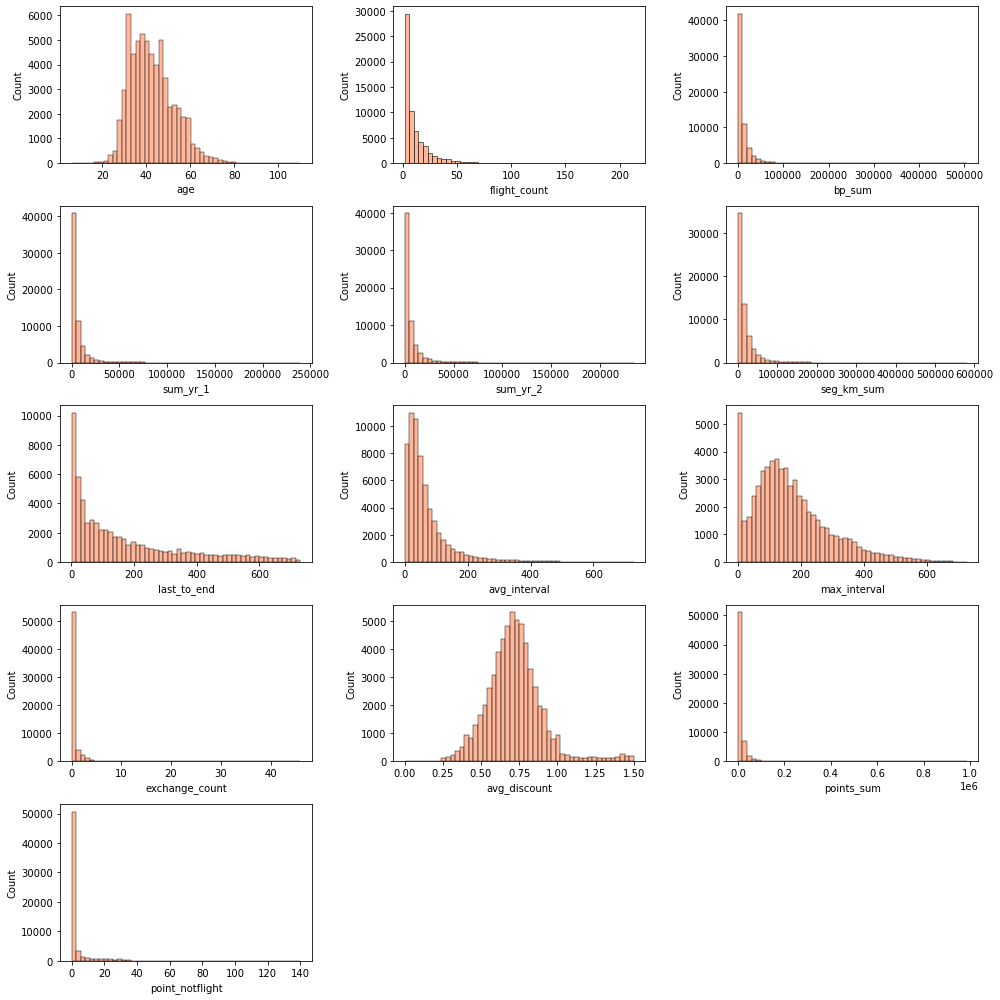

In [32]:
#draw distribution plot
plt.figure(figsize=(14, 14))

for i in range(len(nums)):
    plt.subplot(5, 3, i+1)
    sns.histplot(data=flight, x=nums[i], color='lightsalmon', bins=50)
    plt.xlabel(nums[i])
    plt.tight_layout()
plt.savefig('distplotawal.png')

Almost all columns are right-skewed, only `avg-discount` has normal distribution.

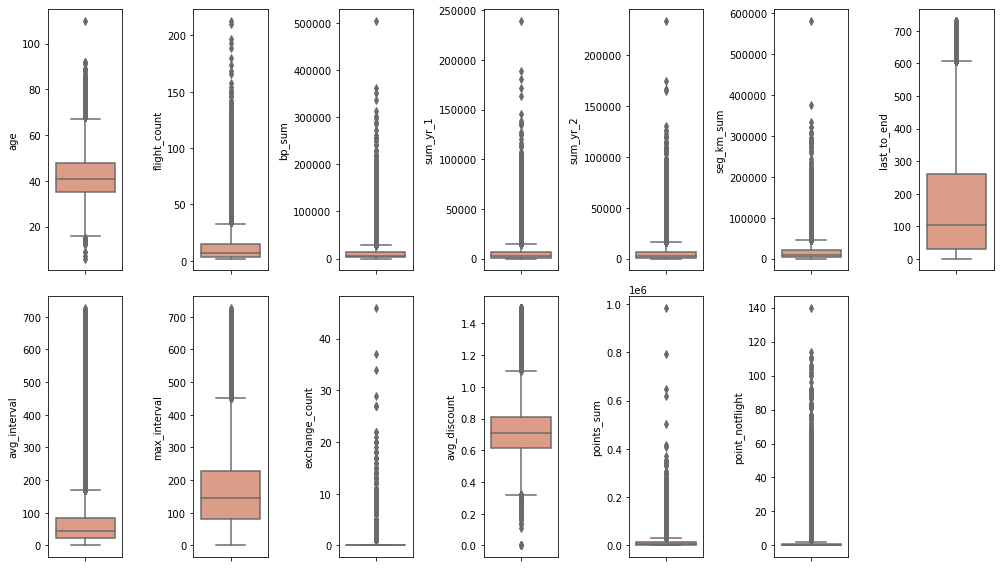

In [33]:
#draw boxplot to spot outliers
plt.figure(figsize=(14, 8))

for i in range(len(nums)):
    plt.subplot(2, len(nums)//2 + 1, i+1)
    sns.boxplot(y=flight[nums[i]], color='darksalmon')
    plt.tight_layout()
plt.savefig('boxplotawal.png')

All columns have fair amount of outliers.

### 2.3. Bivariate Analysis

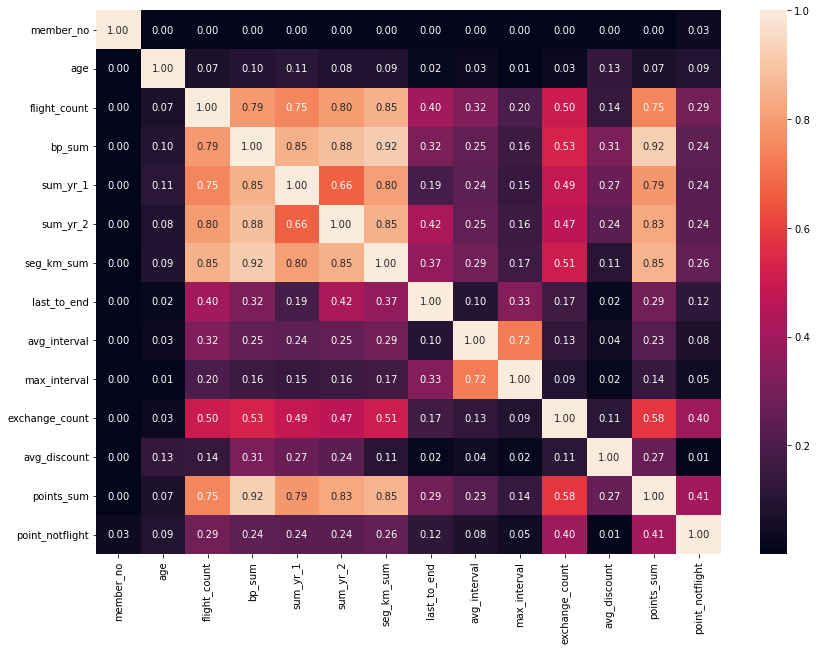

In [34]:
# heatmap correlation
corr = flight.corr().abs()

plt.figure(figsize=(14,10))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.savefig('corrplotawal.png')
plt.show()

Column `flight_count`, `bp_sum`, `sum_yr_1`, `sum_yr_2`, `seg_km_sum` are highly correlated each other, which is make sense. The more frequent the customer purchases or flies, the further the flight distance covers and the more the fare revenues.  

`points_sum` or total point by the customer is accumulated by the booking purchase (`bp_sum`). The more purchase, the customer will get more points.

### 2.4. Deep Dive Analysis

**What is the Top 10 Country that the Customers come from?** 

Text(0.5, 0, 'count')

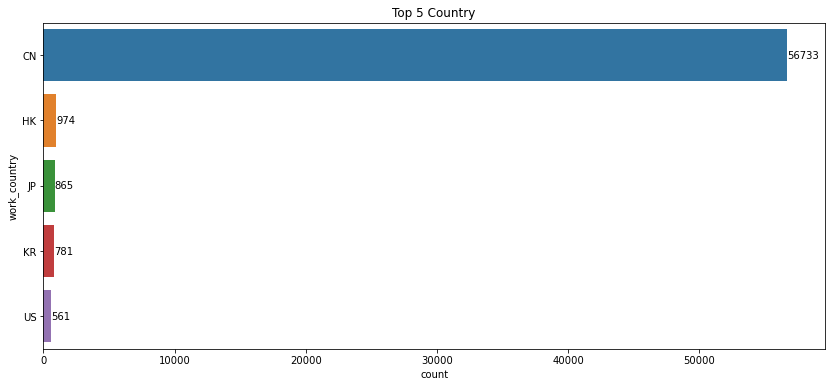

In [22]:
topcountry = flight.groupby('work_country').size().sort_values(ascending=False).reset_index()
top5country = topcountry.head(5)

plt.figure(figsize=(14, 6))
ax = sns.barplot(x=0, y="work_country", data=top5country)
plt.bar_label(ax.containers[0])
plt.title('Top 5 Country')
plt.xlabel('count')

Most customers come from China itself (91.71%), considering this dataset origins from a Chinese airline, followed by its neighbour country, Hong Kong, South Korea, Japan, and US.

**How is the Proportion of Local and International Customer?**

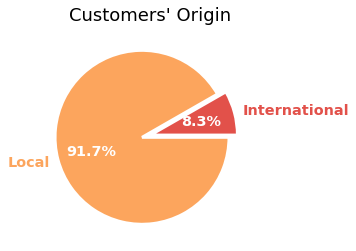

In [25]:
#group customers based on their country
topcountry = flight.groupby('work_country').size().sort_values(ascending=False).reset_index()
#replace 'CN' with local, and international by the rest
topcountry['work_country'] = np.where(topcountry['work_country'] == 'CN', 'Local', 'International')
#group by customers by local and international
topcountry = topcountry.groupby(['work_country'])[0].sum()

#create a pie chart
subset = pd.DataFrame(topcountry).reset_index()
patches, texts, pcts = plt.pie(x=subset[0], labels=subset['work_country'], explode=(0.0, 0.1), autopct='%1.1f%%', 
        colors=sns.color_palette("Spectral"), wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, textprops={'size': 'x-large'})
# For each wedge, set the corresponding text label color to the wedge's
# face color.
for i, patch in enumerate(patches):
  texts[i].set_color(patch.get_facecolor())
plt.setp(pcts, color='white', fontweight='bold')
plt.setp(texts, fontweight=600)
plt.title("Customers' Origin", fontsize=18)
plt.savefig('customers_origin.png')
plt.show()

**What is the Top 10 International Customers come from?**

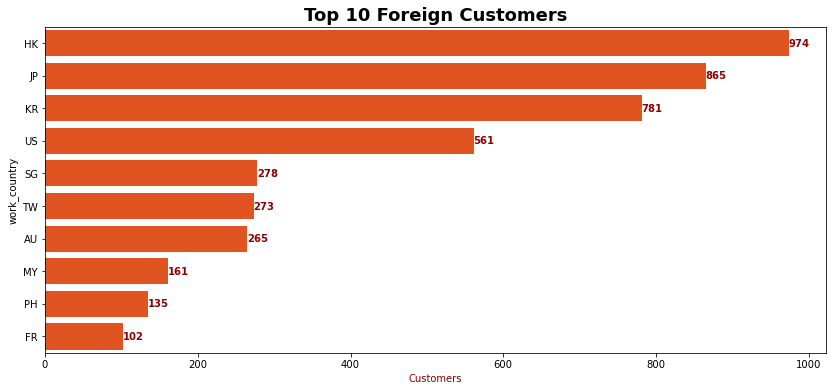

In [39]:
#group customers based on their country
topinternational = flight[flight['work_country']!= 'CN'].groupby('work_country').size().sort_values(ascending=False).reset_index()
topinternational

plt.figure(figsize=(14, 6))
ax = sns.barplot(x=0, y="work_country", data=topinternational.head(10), color='orangered')
plt.bar_label(ax.containers[0], color='darkred', fontweight='bold')
plt.title('Top 10 Foreign Customers', fontsize=18, fontweight='bold')
plt.xlabel('Customers', color='darkred')
plt.savefig('topinternational.png')

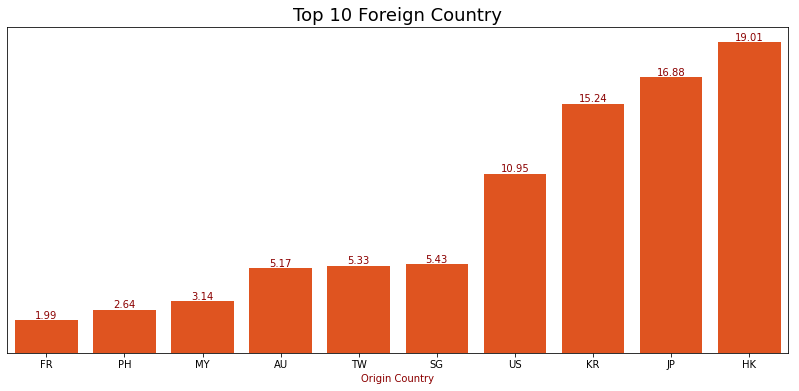

In [53]:
#group customers based on their country
topinternational = flight[flight['work_country']!= 'CN'].groupby('work_country').size().sort_values(ascending=True).reset_index()
topinternational['%'] = np.round(topinternational[0]*100/topinternational[0].sum(), 2)
topinternational

f = plt.figure(figsize=(14, 6))
ax = f.add_subplot(111)
ax.yaxis.tick_right()
ax = sns.barplot(x="work_country", y="%", data=topinternational.tail(10), color='orangered')
ax.get_yaxis().set_visible(False)
plt.bar_label(ax.containers[0], color='darkred')
plt.title('Top 10 Foreign Country', fontsize=18)
plt.ylabel('% Customers', color='darkred')
plt.xlabel('Origin Country', color='darkred')
plt.savefig('topinternational.png')

**What is the Top 5 Local Province that the Customers come from?**

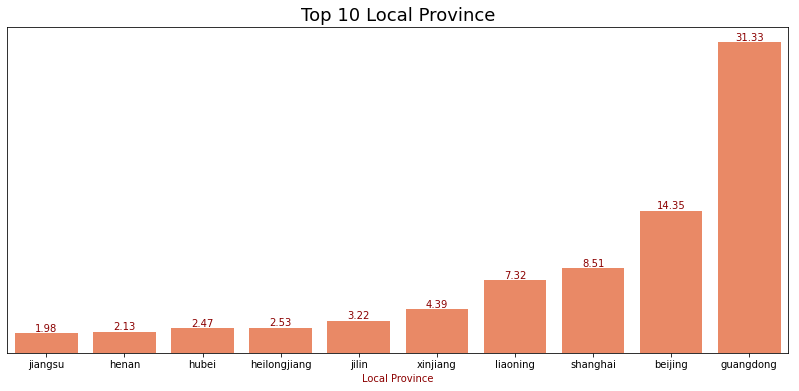

In [61]:
localflight = flight[(flight['work_country'] == 'CN') & (flight['work_province'] != 'Unknown')]
localflight['work_province'] = localflight['work_province'].str.replace(' ', '').str.lower() 
topprovince = localflight.groupby('work_province').size().sort_values(ascending=True).reset_index()
topprovince['%'] = np.round(topprovince[0]*100/topprovince[0].sum(), 2)
top10province = topprovince.tail(10)

f = plt.figure(figsize=(14, 6))
ax = f.add_subplot(111)
ax.yaxis.tick_right()
ax = sns.barplot(x="work_province", y="%", data=top10province, color='coral')
ax.get_yaxis().set_visible(False)
plt.bar_label(ax.containers[0], color='darkred')
plt.title('Top 10 Local Province', fontsize=18)
plt.xlabel('Local Province', color='darkred')
plt.savefig('topprovince.png')

**How is the proportion of Customers' Gender and FFP Tier?**

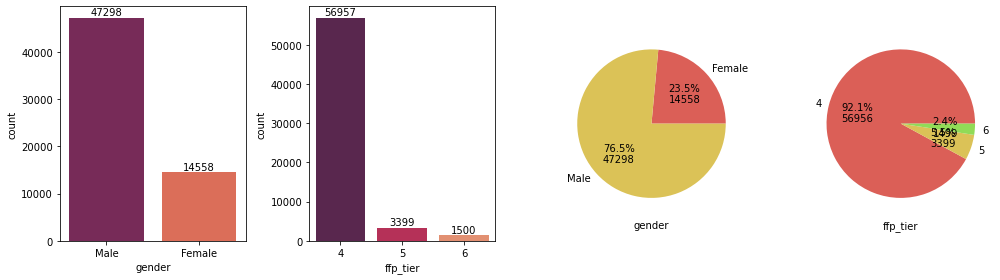

In [69]:
#show countplot for gender and ffp_tier columns
cols = ['gender', 'ffp_tier']

plt.figure(figsize=(14, 4))
for i in range(len(cols)):
    plt.subplot(1, 4, i+1)
    ax = sns.countplot(x=flight[cols[i]], palette='rocket')
    plt.bar_label(ax.containers[0])
    plt.tight_layout()

#create a pie chart
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n{:d}".format(pct, absolute)

for i in range(len(cols)):
    subset = pd.DataFrame(flight.groupby(cols[i]).size()).reset_index()
    plt.subplot(1, 4, i+3)
    plt.pie(x=subset[0], labels=subset[cols[i]], autopct=lambda pct: func(pct, subset[0]), 
            colors=sns.color_palette("hls", 8))    
    plt.xlabel(cols[i])
    plt.tight_layout()

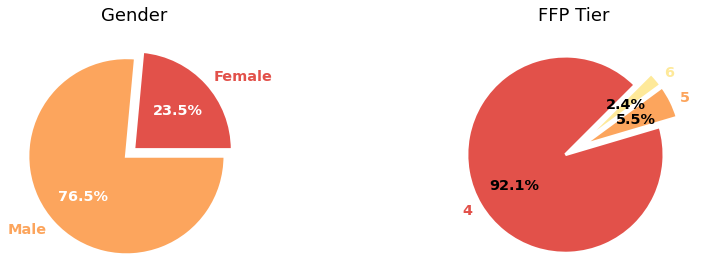

In [41]:
plt.figure(figsize=(14, 4))

#create a pie chart for gender
gender = pd.DataFrame(flight.groupby('gender').size()).reset_index()
plt.subplot(1, 2, 1)
patches, texts, pcts = plt.pie(x=gender[0], labels=gender['gender'], explode=(0.0, 0.1), autopct='%1.1f%%', 
        colors=sns.color_palette("Spectral"), wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, textprops={'size': 'x-large'})
# For each wedge, set the corresponding text label color to the wedge's
# face color.
for i, patch in enumerate(patches):
  texts[i].set_color(patch.get_facecolor())
plt.setp(pcts, color='white', fontweight='bold')
plt.setp(texts, fontweight=600)
plt.title('Gender', fontsize=18)
plt.savefig('gender.png')

#create a pie chart for ffp tier
ffp_tier = pd.DataFrame(flight.groupby('ffp_tier').size()).reset_index()
plt.subplot(1, 2, 2)
patches, texts, pcts = plt.pie(x=ffp_tier[0], labels=ffp_tier['ffp_tier'], explode=(0.1, 0.1, 0.1), autopct='%1.1f%%', 
        colors=sns.color_palette("Spectral"), wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, textprops={'size': 'x-large'}, 
        startangle=45)
# For each wedge, set the corresponding text label color to the wedge's
# face color.
for i, patch in enumerate(patches):
  texts[i].set_color(patch.get_facecolor())
plt.setp(pcts, color='black', fontweight='bold')
plt.setp(texts, fontweight=600)
plt.title('FFP Tier', fontsize=18)
plt.savefig('ffp_tier.png')

plt.tight_layout()
plt.show()

`gender` : 

    Most of customers are male, takes up 76.5% of total customers.

`ffp_tier` : 
    
    A frequent-flyer program is a loyalty program offered by an airline. Many airlines have frequent-flyer programs designed to encourage airline customers enrolled in the program to accumulate points which may then be redeemed for air travel or other rewards.

    There are three levels of FFP, 4 to 6. Almost all customers are from tier 4 of FFP, takes up 92.1%

**Customers' Age Groups**

Based on generation, there are 5 different age groups, namely
* Baby Boomers: Born 1946-1964 --> >=58 years old
* Generation X: Born 1965-1980 --> 42-57 years old
* Millennials: Born 1981-1996 --> 26-41 years old
* Generation Z: Born 1997-2012 --> <25 years old

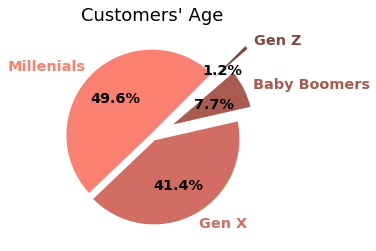

In [63]:
def gen(x):
    if x <= 25:
        return 'Gen Z'
    elif (x > 25) & (x <= 41):
        return 'Millenials'
    elif (x > 41) & (x <= 57):
        return 'Gen X'
    else:
        return 'Baby Boomers'

agegroup = flight[['age']]
agegroup['gen'] = agegroup['age'].apply(gen)
custgen = pd.DataFrame(agegroup.groupby('gen').size().sort_values(ascending=False)).reset_index()
custgen

patches, texts, pcts = plt.pie(x=custgen[0], labels=custgen['gen'], explode=(0.0, 0.05, 0.2, 0.5), autopct='%1.1f%%', 
        colors=sns.color_palette("dark:salmon_r"), wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, textprops={'size': 'x-large'}, 
        startangle=45)
# For each wedge, set the corresponding text label color to the wedge's
# face color.
for i, patch in enumerate(patches):
  texts[i].set_color(patch.get_facecolor())
plt.setp(pcts, color='black', fontweight='bold')
plt.setp(texts, fontweight=600)
plt.title("Customers' Age", fontsize=18)
plt.savefig('age.png')
plt.show()

**Which Generation Travels the Most**

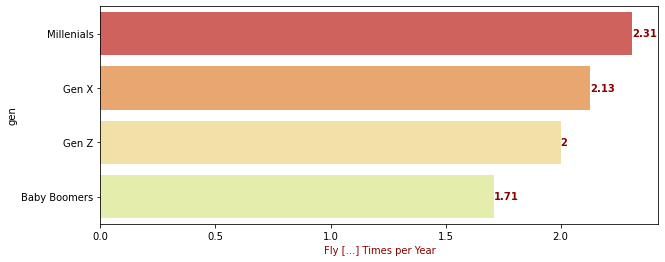

In [68]:
custgen2 = flight.copy()
custgen2['gen'] = custgen2['age'].apply(gen)

#create feature L from load_time and ffp_date column
from dateutil import relativedelta

# Get the interval between two dates
def L(load_time, ffp_date):
    diff = relativedelta.relativedelta(load_time, ffp_date)
    diff_in_months = diff.months + diff.years * 12
    return diff_in_months

custgen2['L'] = custgen2.apply(lambda x: L(x['load_time'], x['ffp_date']), axis = 1)
custgen2['M/F(km)'] = custgen2['seg_km_sum']/custgen2['flight_count']
custgen2['F/L (/yr)'] = custgen2['flight_count']/(custgen2['L']/12)

custgengroup = pd.DataFrame(custgen2.groupby('gen').agg({'F/L (/yr)':'median', 'M/F(km)':'median'}).sort_values('F/L (/yr)', ascending=False)).reset_index()
custgengroup['F/L (/yr)'] = custgengroup.apply(lambda x: round(x['F/L (/yr)'], 2), axis=1)
custgengroup

plt.figure(figsize=(10, 4))
ax = sns.barplot(x='F/L (/yr)', y="gen", data=custgengroup, palette=sns.color_palette("Spectral"))
plt.bar_label(ax.containers[0], color='darkred', fontweight='bold')
#plt.title('Travel Frequency per Year for Each Generation', fontsize=14)
plt.xlabel('Fly [...] Times per Year', color='darkred')
#plt.ylabel('Generation')
plt.savefig('frequencygen.png')
plt.show()

**FFP Tier**

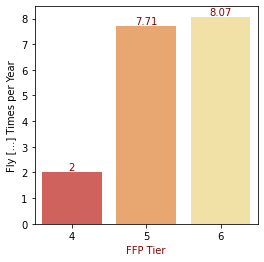

In [69]:
ffpgroup = pd.DataFrame(custgen2.groupby('ffp_tier').agg({'F/L (/yr)':'median', 'M/F(km)':'median'}).sort_values('F/L (/yr)', ascending=False)).reset_index()
ffpgroup['F/L (/yr)'] = ffpgroup.apply(lambda x: round(x['F/L (/yr)'], 2), axis=1)
ffpgroup

plt.figure(figsize=(4, 4))
ax = sns.barplot(x='ffp_tier', y="F/L (/yr)", data=ffpgroup, palette=sns.color_palette("Spectral"))
plt.bar_label(ax.containers[0], color='darkred')
#plt.title('Travel Frequency per Year for FFP Tier Holder', fontsize=14)
plt.ylabel('Fly [...] Times per Year')
plt.xlabel('FFP Tier', color='darkred')
plt.savefig('frequencyffp.png')
plt.show()

In [77]:
custgen2[(custgen2['F/L (/yr)'] > 7) & (custgen2['ffp_tier'] == 4)]

,member_no,ffp_date,first_flight_date,gender,ffp_tier,work_city,work_province,work_country,age,load_time,...,avg_interval,max_interval,exchange_count,avg_discount,points_sum,point_notflight,gen,L,M/F(km),F/L (/yr)
114,60020,2012-06-07,2012-06-16,Female,4,LOS ANGELES,LA,US,49.0,2014-03-31,...,41.866667,150,0,0.753750,133754,1,Gen X,21,12232.000000,9.142857
133,59669,2012-04-11,2012-07-30,Male,4,dongguan,guangdong,CN,62.0,2014-03-31,...,42.461538,208,2,0.973673,179310,3,Baby Boomers,23,10336.285714,7.304348
258,13818,2010-04-25,2010-04-25,Male,4,guangzhou,guangdong,CN,54.0,2014-03-31,...,11.709091,60,3,0.995828,121166,8,Gen X,47,2042.107143,14.297872
269,39208,2010-08-28,2010-08-29,Male,4,NEYAGAWA,OSAKAFU,JP,48.0,2014-03-31,...,12.826923,76,8,0.828408,127389,14,Gen X,43,2540.132075,14.790698
275,4234,2009-08-07,2010-01-17,Male,4,guangzhou,guangdong,CN,37.0,2014-03-31,...,7.732558,49,3,0.962307,125094,9,Millenials,55,1323.379310,18.981818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50207,60939,2013-01-20,2013-03-31,Male,4,shantou,guangdong,CN,55.0,2014-03-31,...,42.875000,77,0,0.732222,2100,0,Gen X,14,413.000000,7.714286
50676,43542,2013-02-15,2013-04-21,Female,4,HK,HK,HK,38.0,2014-03-31,...,36.571429,126,0,0.357423,708,0,Millenials,13,927.500000,7.384615
51133,1850,2012-11-11,2013-05-04,Female,4,changsha,hunan,CN,24.0,2014-03-31,...,33.555556,62,0,0.381796,765,0,Gen Z,16,675.800000,7.500000
52295,25236,2012-11-15,2012-11-17,Male,4,fukang,xinjiang,CN,50.0,2014-03-31,...,41.416667,121,0,0.642308,3200,0,Gen X,16,289.000000,9.750000


5969 customers should be offered FFP Tier upgrade from 4 to 5

In [78]:
custgen2[(custgen2['F/L (/yr)'] > 8) & (custgen2['ffp_tier'] == 5)]

,member_no,ffp_date,first_flight_date,gender,ffp_tier,work_city,work_province,work_country,age,load_time,...,avg_interval,max_interval,exchange_count,avg_discount,points_sum,point_notflight,gen,L,M/F(km),F/L (/yr)
8,32197,2011-06-07,2011-07-01,Male,5,DRANCY,Unknown,FR,50.0,2014-03-31,...,13.054545,94,5,0.828478,295158,7,Gen X,33,5740.875000,20.363636
24,58472,2010-02-14,2010-03-01,Female,5,Unknown,Unknown,FR,48.0,2014-03-31,...,15.883721,66,10,0.787308,235939,12,Gen X,49,6405.386364,10.775510
43,58798,2010-05-04,2010-05-14,Male,5,guangzhou,guangdong,CN,51.0,2014-03-31,...,15.888889,54,0,0.764737,191878,2,Gen X,46,5581.869565,12.000000
49,22629,2010-07-15,2010-07-15,Male,5,SUMIDA-KU,TOKYO-TO,JP,49.0,2014-03-31,...,6.028986,32,8,0.863479,199386,9,Gen X,44,3132.600000,19.090909
59,11034,2005-01-26,2005-03-09,Male,5,beijing,.,CN,59.0,2014-03-31,...,9.133333,34,5,0.819187,190530,13,Baby Boomers,110,2827.907895,8.290909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28926,43384,2013-01-01,2013-01-06,Male,5,wuhan,hubei,CN,47.0,2014-03-31,...,21.947368,108,0,0.750780,8825,1,Gen X,14,524.150000,17.142857
29532,51635,2012-07-22,2012-07-22,Male,5,.,beijing,CN,38.0,2014-03-31,...,40.466667,189,0,0.790090,6738,0,Millenials,20,605.500000,9.600000
35936,6607,2012-06-12,2012-06-19,Male,5,guangzhou,guangdong,CN,48.0,2014-03-31,...,39.000000,232,0,0.624000,3926,0,Gen X,21,604.000000,8.571429
40073,6343,2012-05-22,2012-05-24,Male,5,yining,wulumuqi,CN,43.0,2014-03-31,...,47.785714,468,0,0.586195,4400,1,Gen X,22,527.266667,8.181818


1625 customers should be offered FFP Tier upgrade from 5 to 6

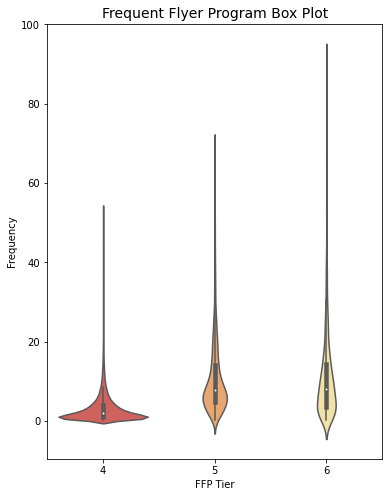

In [88]:
plt.figure(figsize=(6, 8))
sns.violinplot(data=custgen2, x='ffp_tier',  y='F/L (/yr)', palette=sns.color_palette("Spectral"))
plt.title('Frequent Flyer Program Box Plot', fontsize=14)
plt.ylabel('Frequency')
plt.xlabel('FFP Tier')
plt.savefig('ffp_boxplot.png')
plt.show()

## 3. Data Preprocessing

In [16]:
#copy dataset
df = flight.copy()
df.head()

,member_no,ffp_date,first_flight_date,gender,ffp_tier,work_city,work_province,work_country,age,load_time,...,sum_yr_2,seg_km_sum,last_flight_date,last_to_end,avg_interval,max_interval,exchange_count,avg_discount,points_sum,point_notflight
0,54993,2006-11-02,2008-12-24,Male,6,.,beijing,CN,31.0,2014-03-31,...,234188.0,580717,2014-03-31,1,3.483254,18,34,0.961639,619760,50
1,28065,2007-02-19,2007-08-03,Male,6,Unknown,beijing,CN,42.0,2014-03-31,...,167434.0,293678,2014-03-25,7,5.194245,17,29,1.252314,415768,33
2,55106,2007-02-01,2007-08-30,Male,6,.,beijing,CN,40.0,2014-03-31,...,164982.0,283712,2014-03-21,11,5.298507,18,20,1.254676,406361,26
3,21189,2008-08-22,2008-08-23,Male,5,Los Angeles,CA,US,64.0,2014-03-31,...,125500.0,281336,2013-12-26,97,27.863636,73,11,1.090870,372204,12
4,39546,2009-04-10,2009-04-15,Male,6,guiyang,guizhou,CN,48.0,2014-03-31,...,130702.0,309928,2014-03-27,5,4.788079,47,27,0.970658,338813,39


### 3.1. Feature Selection

Refer to `Tao, Y.: Analysis Method for Customer Value of Aviation Big Data Based on LFRMC Model. ICPCSEE 2020, CCIS 1257. 89-100(2020).`

According to the LRFMC model of airline customer value, six attributes related to the LRFMC model indexes are selected: FFP DATE, LOAD_TIM, FLIGHT COUNT, AVG DISCOUNT, SEG KM SUM and LAST TO END.

In [17]:
#only include selected features
df = df[['ffp_date', 'load_time', 'flight_count', 'avg_discount', 'seg_km_sum', 'last_to_end']]
df.head()

,ffp_date,load_time,flight_count,avg_discount,seg_km_sum,last_to_end
0,2006-11-02,2014-03-31,210,0.961639,580717,1
1,2007-02-19,2014-03-31,140,1.252314,293678,7
2,2007-02-01,2014-03-31,135,1.254676,283712,11
3,2008-08-22,2014-03-31,23,1.090870,281336,97
4,2009-04-10,2014-03-31,152,0.970658,309928,5


### 3.2. Feature Engineering

Because the original data does not directly give the five indicators of LRFMC, the five indicators need to be extracted from the original data. The specific calculation method is as follows:

* **Loyalty** = LOAD_TIME - FFP_DATE

    The number of months between the time of membership and the end of observation window = the end time of observation window - the time of membership (unit: month). 
    
    The higher the loyalty value is, the better, and vice versa. 


* **Recency** = LAST_TO_END

    The number of months from the last time the customer took the company's aircraft to the end of the observation window = the time from the last flight to the end of the observation window (unit: month].
    
    The lower the recency value is, the better, and vice versa.


* **Frequency** = FLIGHT COUNT

    Number of times the customer takes the company's aircraft in the observation window = number of flights in the observation window (unit: Times).
    
    The higher the frequency value is, the better, and vice versa.


* **Monetary** = SEG_KM_SUM

    Accumulated flight history of the customer in observation time = total flight kilometers of observation window (unit: km).
    
    The higher the monetary value is, the better, and vice versa.


* **Cabin** = AVG DISCOUNT

    Average value of the discount coefficient corresponding to the passenger space during the observation time = average discount rate (unit: none).
    
    The higher the cabin value is, the better, and vice versa.

In [18]:
#create feature L from load_time and ffp_date column
from dateutil import relativedelta

# Get the interval between two dates
def L(load_time, ffp_date):
    diff = relativedelta.relativedelta(load_time, ffp_date)
    diff_in_months = diff.months + diff.years * 12
    return diff_in_months

df['L'] = df.apply(lambda x: L(x['load_time'], x['ffp_date']), axis = 1)

In [19]:
#rename columns
df.rename(columns = {'L':'Loyalty', 'last_to_end':'Recency', 'flight_count':'Frequency', 'seg_km_sum':'Monetary', 'avg_discount':'Cabin'}, inplace = True)

#drop load_time and ffp_date
df = df.drop(columns = ['load_time', 'ffp_date'])

#reorder columns
df = df[['Loyalty', 'Recency', 'Frequency', 'Monetary', 'Cabin']]

In [20]:
df.head()

,Loyalty,Recency,Frequency,Monetary,Cabin
0,88,1,210,580717,0.961639
1,85,7,140,293678,1.252314
2,85,11,135,283712,1.254676
3,67,97,23,281336,1.090870
4,59,5,152,309928,0.970658


In [21]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Loyalty,61856.0,48.265714,27.819575,12.0,24.00000,41.000000,71.000000,112.0
Recency,61856.0,172.606942,181.234370,1.0,29.00000,105.000000,260.000000,731.0
Frequency,61856.0,11.964401,14.116064,2.0,3.00000,7.000000,15.000000,213.0
Monetary,61856.0,17303.810027,21040.271177,368.0,4866.75000,10183.000000,21497.500000,580717.0
Cabin,61856.0,0.721649,0.184792,0.0,0.61265,0.711827,0.808825,1.5


**Distribution Plot**

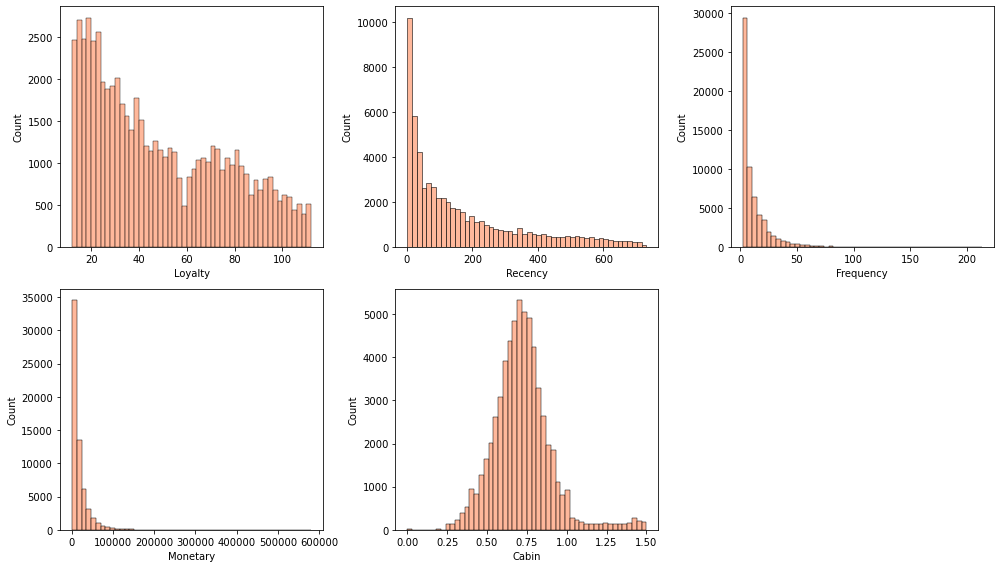

In [25]:
#draw distribution plot
plt.figure(figsize=(14, 8))

for i in range(len(df.columns)):
    plt.subplot(2, 3, i+1)
    sns.histplot(data=df, x=df.columns[i], color='lightsalmon', bins=50)
    plt.xlabel(df.columns[i])
    plt.tight_layout()
plt.savefig('distplotLRFMC.png')

**Box Plot to Detect Outliers** 

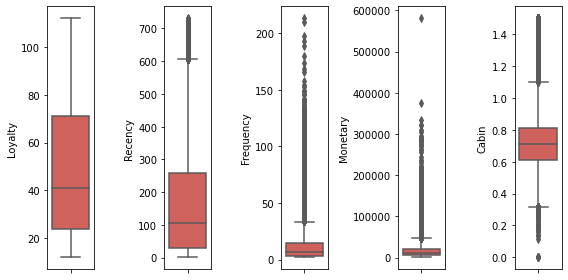

In [26]:
plt.figure(figsize=(8, 4))

for i in range(len(df.columns)):
    plt.subplot(1, len(df.columns), i+1)
    sns.boxplot(y=df[df.columns[i]], palette=sns.color_palette("Spectral"))
    plt.tight_layout()
plt.savefig('boxplotLRFMC.png')

Only Length column that has no outier in it. Other columns has many outliers that we will count its significancy towards data.

### 3.3. Outliers Handling

Since K-Means Clustering is sensitive with range, we should handle the outlier wisely to optimize our modelling process and improve the result. Here we will inspect the outliers from each column.

**Outliers Percentage**

In [27]:
#count the outliers for each columns
def find_outliers_IQR(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    IQR = q3-q1
    outliers = df[col][((df[col]<(q1-1.5*IQR)) | (df[col]>(q3+1.5*IQR)))]
    return outliers

for i in range(len(df.columns)):
    outliers = find_outliers_IQR(df, df.columns[i])
    outliers_pct = len(outliers)/len(df[df.columns[i]])
    print(f'outliers percentage for column {df.columns[i]} is ', outliers_pct)

outliers percentage for column Loyalty is  0.0
outliers percentage for column Recency is  0.03493598034143818
outliers percentage for column Frequency is  0.06935463010863942
outliers percentage for column Monetary is  0.07595059493016038
outliers percentage for column Cabin is  0.041257113295395755


**Replace with the tenth and ninetieth percentile**

In [28]:
df_out = df.copy()

#replace the outliers
def replace_outliers(df, col):
    # Computing 10th, 90th percentiles
    tenth_percentile = np.percentile(df[col], 10)
    ninetieth_percentile = np.percentile(df[col], 90)
    b = np.where(df[col]<tenth_percentile, tenth_percentile, df[col])
    b = np.where(b>ninetieth_percentile, ninetieth_percentile, b)
    return b

col = ['Recency', 'Frequency', 'Monetary', 'Cabin']
for i in range(len(col)):
    df_out[col[i]] = replace_outliers(df_out, col[i])

df_out.head()

,Loyalty,Recency,Frequency,Monetary,Cabin
0,88,8.0,28.0,40030.5,0.92
1,85,8.0,28.0,40030.5,0.92
2,85,11.0,28.0,40030.5,0.92
3,67,97.0,23.0,40030.5,0.92
4,59,8.0,28.0,40030.5,0.92


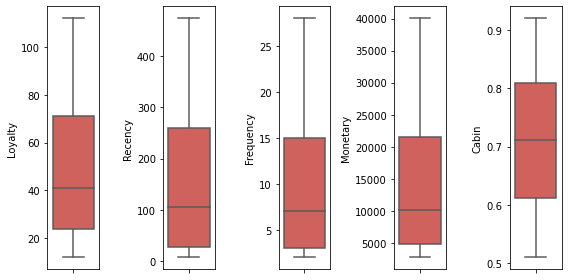

In [29]:
plt.figure(figsize=(8, 4))

for i in range(len(df_out.columns)):
    plt.subplot(1, len(df_out.columns), i+1)
    sns.boxplot(y=df_out[df_out.columns[i]], palette=sns.color_palette("Spectral"))
    plt.tight_layout()
plt.savefig('boxplotLRFMC2.png')

### 3.3.  Feature Scaling with LRFMC Scoring

Scoring use scale 1 - 5. For Loyalty, Frequency, Monetary, and Cabin, the higher the value, the higher score they get, vice versa. For Recency, the lower the value, the higher the score they get, and vice versa. The scoring will be based on quintile.

In [117]:
#copy dataset
df_score = df_out.copy()

#scoring
for col in df_score.columns:
    df_score[col]= pd.qcut(df_score[col], q = 5, labels = False) + 1

#scoring for Recency column
dict_map = {1:5, 2:4, 3:3, 4:2, 5:1}
df_score['Recency'] = df_score['Recency'].map(dict_map)

df_score.head()

,Loyalty,Recency,Frequency,Monetary,Cabin
0,5,5,5,5,5
1,5,5,5,5,5
2,5,5,5,5,5
3,4,3,5,5,5
4,4,5,5,5,5


**Correlation Plot**

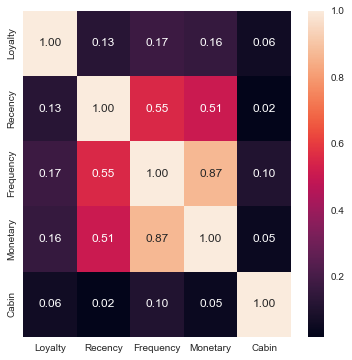

In [118]:
# heatmap correlation
corr = df_score.corr()

plt.figure(figsize=(6,6))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.savefig('corrplot.png')
plt.show()

Feature F (Frequency) and M (Monetary) is highly correlated, which is make sense. The more frequent a customer flies, the further flight distance is.

## 4. Modelling using K-Means Clustering

### 4.1. Hyperparameter (K Value) Tuning 

**Elbow Method**

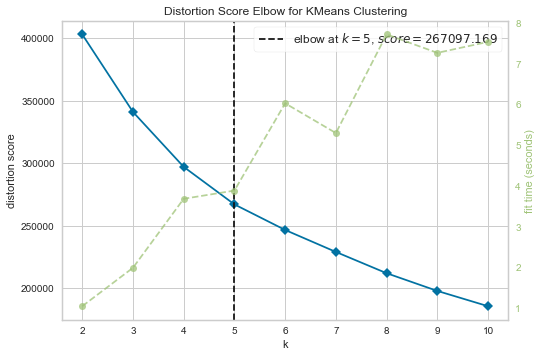

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [99]:
from sklearn.cluster import KMeans

#feature = df_norm.drop(columns=['L', 'R', 'F', 'M', 'C'])
feature = df_score.copy()

# Import ElbowVisualizer  
from yellowbrick.cluster import KElbowVisualizer  
model = KMeans()  

# k is range of number of clusters.  
visualizer = KElbowVisualizer(model, k=(2,11), timings= True)  
visualizer.fit(feature)        # Fit data to visualizer  
visualizer.show()        # Finalize and render figure

Based on the elbow method, k = 5.

### 4.2. Clustering Result

After choosing the best k, we fit and give cluster label to dataset

In [119]:
# run kmeans with the optimal K
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(feature.values)

#store cluster label in an additional column
feature['cluster'] = kmeans.labels_

In [121]:
#clustering result
feature.head()

,Loyalty,Recency,Frequency,Monetary,Cabin,cluster
0,5,5,5,5,5,3
1,5,5,5,5,5,3
2,5,5,5,5,5,3
3,4,3,5,5,5,3
4,4,5,5,5,5,3


In [122]:
df['cluster'] = kmeans.labels_
df

,Loyalty,Recency,Frequency,Monetary,Cabin,cluster
0,88,1,210,580717,0.961639,3
1,85,7,140,293678,1.252314,3
2,85,11,135,283712,1.254676,3
3,67,97,23,281336,1.090870,3
4,59,5,152,309928,0.970658,3
...,...,...,...,...,...,...
62982,14,437,2,3848,0.000000,4
62983,34,297,2,1134,0.000000,4
62984,48,89,4,8016,0.000000,2
62985,96,29,2,2594,0.000000,2


In [123]:
df_out['cluster'] = kmeans.labels_
df_out

,Loyalty,Recency,Frequency,Monetary,Cabin,cluster
0,88,8.0,28.0,40030.5,0.920000,3
1,85,8.0,28.0,40030.5,0.920000,3
2,85,11.0,28.0,40030.5,0.920000,3
3,67,97.0,23.0,40030.5,0.920000,3
4,59,8.0,28.0,40030.5,0.920000,3
...,...,...,...,...,...,...
62982,14,437.0,2.0,3848.0,0.510231,4
62983,34,297.0,2.0,2766.0,0.510231,4
62984,48,89.0,4.0,8016.0,0.510231,2
62985,96,29.0,2.0,2766.0,0.510231,2


### 4.3. Clustering Visualization

For better segmentation analysis, we will visualize the clustering by two-dimensional scatter plot and radar chart for each cluster. 

### 4.3.1. Clustering Scatter Plot

**Recency x Frequency x Monetary**

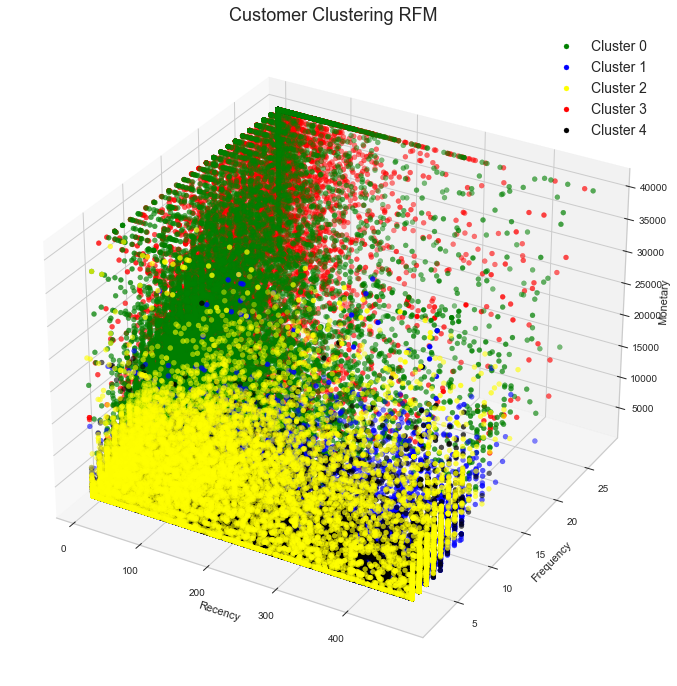

In [142]:
#plot 3D dengan hasil cluster
fig = plt.figure(figsize=(12,12))
dx = fig.add_subplot(111, projection='3d')
colors = ['green', 'blue', 'yellow', 'red','black']
for i in range(0,5):
    dx.scatter(df_out[df_out.cluster == i].Recency,
    df_out[df_out.cluster == i].Frequency,
    df_out[df_out.cluster == i].Monetary,
               c = colors[i], label = 'Cluster ' + str(i), s=25)
dx.set_title('Customer Clustering RFM', fontsize=18)
dx.set_xlabel('Recency')
dx.set_ylabel('Frequency')
dx.set_zlabel('Monetary')
dx.legend(fontsize=14)
plt.savefig('RFMClusters.png')
plt.show()

**Loyalty x Frequency x Cabin**

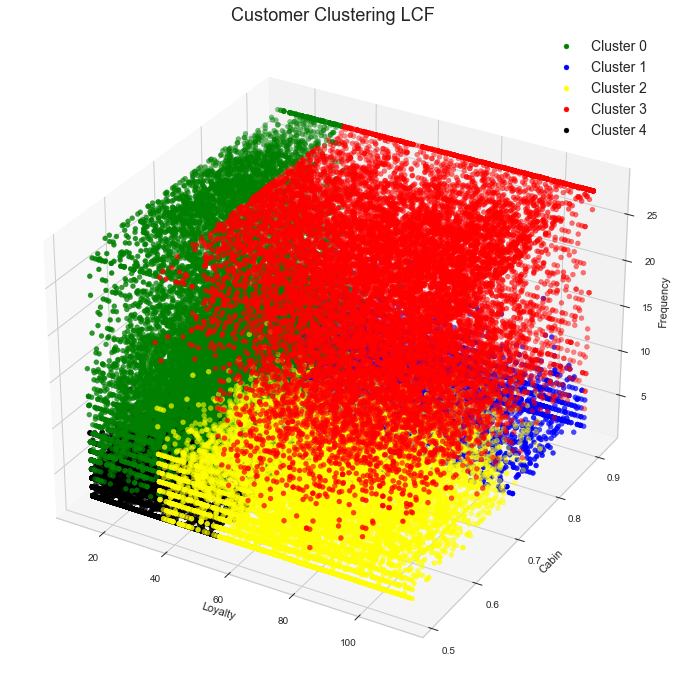

In [146]:
#plot 3D dengan hasil cluster
fig = plt.figure(figsize=(12,12))
dx = fig.add_subplot(111, projection='3d')
colors = ['green', 'blue', 'yellow', 'red','black']
for i in range(0,5):
    dx.scatter(df_out[df_out.cluster == i].Loyalty,
    df_out[df_out.cluster == i].Cabin,
    df_out[df_out.cluster == i].Frequency,
            c = colors[i], label = 'Cluster ' + str(i), s=25)
dx.set_title('Customer Clustering LCF', fontsize=18)
dx.set_xlabel('Loyalty')
dx.set_ylabel('Cabin')
dx.set_zlabel('Frequency')
dx.legend(fontsize=14)
plt.savefig('LCFCluster.png')
plt.show()

**Recency x Frequency x Cabin**

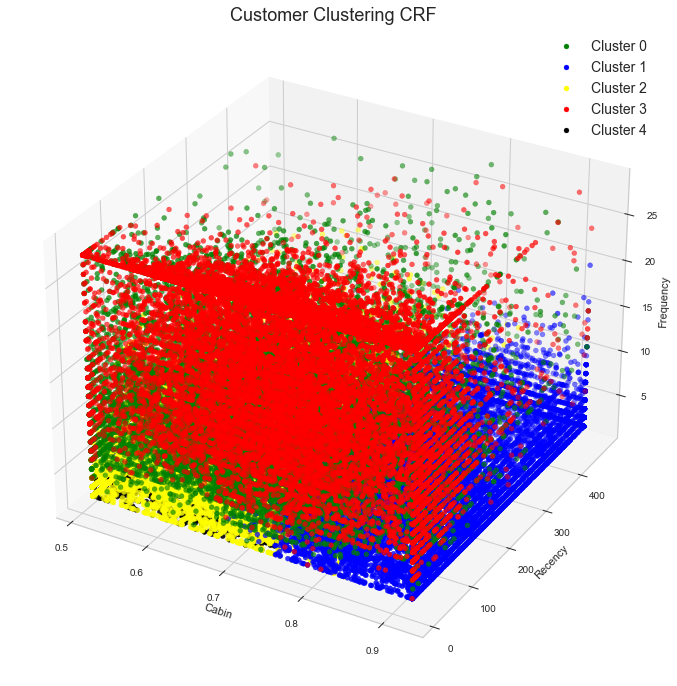

In [147]:
#plot 3D dengan hasil cluster
fig = plt.figure(figsize=(12,12))
dx = fig.add_subplot(111, projection='3d')
colors = ['green', 'blue', 'yellow', 'red','black']
for i in range(0,5):
    dx.scatter(df_out[df_out.cluster == i].Cabin,
    df_out[df_out.cluster == i].Recency,
    df_out[df_out.cluster == i].Frequency,
            c = colors[i], label = 'Cluster ' + str(i), s=25)
dx.set_title('Customer Clustering CRF', fontsize=18)
dx.set_xlabel('Cabin')
dx.set_ylabel('Recency')
dx.set_zlabel('Frequency')
dx.legend(fontsize=14)
plt.savefig('CRFCluster.png')
plt.show()

**Loyalty x Recency x Cabin**

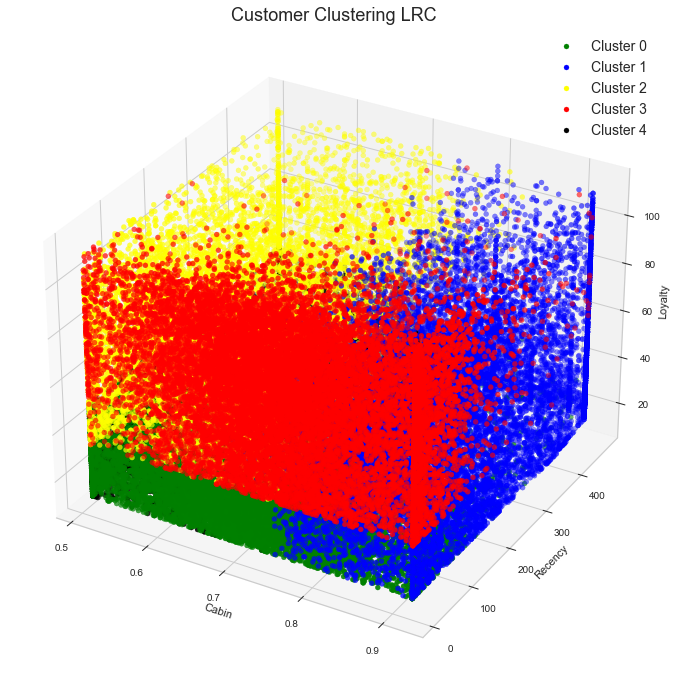

In [148]:
#plot 3D dengan hasil cluster
fig = plt.figure(figsize=(12,12))
dx = fig.add_subplot(111, projection='3d')
colors = ['green', 'blue', 'yellow', 'red','black']
for i in range(0,5):
    dx.scatter(df_out[df_out.cluster == i].Cabin,
    df_out[df_out.cluster == i].Recency,
    df_out[df_out.cluster == i].Loyalty,
            c = colors[i], label = 'Cluster ' + str(i), s=25)
dx.set_title('Customer Clustering LRC', fontsize=18)
dx.set_xlabel('Cabin')
dx.set_ylabel('Recency')
dx.set_zlabel('Loyalty')
dx.legend(fontsize=14)
plt.savefig('LRCCluster.png')
plt.show()

**Calculating Centroid on the Customer Score**

In [149]:
# clusters' centroid analysis
# derive average of each feature (column)
centroid_df = feature.groupby('cluster')[['Loyalty', 'Recency', 'Frequency', 'Monetary', 'Cabin']].agg(
    {'Loyalty': 'mean', 'Recency': 'mean', 'Frequency':'mean', 'Monetary':'mean', 'Cabin': 'mean'}).reset_index()
size = feature.groupby('cluster').size().reset_index()

summary = pd.merge(centroid_df, size, on="cluster")
summary.columns = ['cluster', 'Loyalty', 'Recency', 'Frequency', 'Monetary', 'Cabin', 'Count']
summary['%'] = summary['Count']*100/summary['Count'].sum()
summary

,cluster,Loyalty,Recency,Frequency,Monetary,Cabin,Count,%
0,0,1.829205,3.704766,3.924381,3.953498,2.921918,13806,22.319581
1,1,2.825587,2.014036,1.678708,1.760623,4.498389,13038,21.077988
2,2,4.198403,2.666025,2.181565,2.369095,1.917829,10393,16.801927
3,3,4.231212,4.130691,4.476550,4.461807,3.436369,14584,23.577341
4,4,1.673044,2.040259,1.550673,1.826806,1.647035,10035,16.223163


* `Cluster 0` : Have high score in Recency, Frequency, and Monetary. Average in Cabin. Low in Loyalty.

* `Cluster 1` : Have the highest score in Cabin. Average in Loyalty and Recency. Low in Frequency and Monetary.

* `Cluster 2` : Have the highest score in Loyalty. Average on Recency, Frequency, and Monetary. Low in Cabin.

* `Cluster 3` : Have the highest score in almost all features, except Cabin, although have relatively higher than most.  

* `Cluster 4` : Have the lowest score in all features.

**Calculating Centroid on the Customer Lifetime Value**

In [151]:
#df_clustered = df_clustered[['Loyalty_x', 'Recency_x', 'Frequency_x', 'Monetary_x', 'Cabin_x', 'cluster']]
#df_clustered.columns = ['Loyalty', 'Recency', 'Frequency', 'Monetary', 'Cabin', 'cluster']

centroid_df2 = df.groupby('cluster')[['Loyalty', 'Recency', 'Frequency', 'Monetary', 'Cabin']].agg(
    {'Loyalty': 'median', 'Recency': 'median', 'Frequency':'median', 'Monetary':'median', 'Cabin': 'mean'}).reset_index()
size2 = df.groupby('cluster').size().reset_index()

#merge two dataframe
summary2 = pd.merge(centroid_df2, size2, on="cluster")
summary2.columns = ['cluster', 'Loyalty(month)', 'Recency(month)', 'Frequency(times)', 'Monetary(km)', 'Cabin', 'Count']

#add columns
summary2['%'] = summary2['Count']*100/summary2['Count'].sum()
summary2['M/F(km)'] = summary2['Monetary(km)']/summary2['Frequency(times)']
summary2['F/L (/yr)'] = summary2['Frequency(times)']/(summary2['Loyalty(month)']/12)

summary2 = summary2[['cluster', 'Loyalty(month)', 'Recency(month)', 'Frequency(times)', 'Monetary(km)', 'Cabin', 'F/L (/yr)', 'M/F(km)', 'Count', '%']]
summary2

,cluster,Loyalty(month),Recency(month),Frequency(times),Monetary(km),Cabin,F/L (/yr),M/F(km),Count,%
0,0,25.0,47.0,12.0,18082.0,0.714153,5.760000,1506.833333,13806,22.319581
1,1,39.0,261.0,3.0,4366.0,0.885946,0.923077,1455.333333,13038,21.077988
2,2,71.0,145.0,5.0,7123.0,0.601554,0.845070,1424.600000,10393,16.801927
3,3,73.0,25.0,20.0,28360.5,0.778377,3.287671,1418.025000,14584,23.577341
4,4,22.0,259.0,3.0,4757.0,0.560431,1.636364,1585.666667,10035,16.223163


### 4.3.2. Horizontal Bar Chart for Each Feature

Based on Centroid on Customer Score

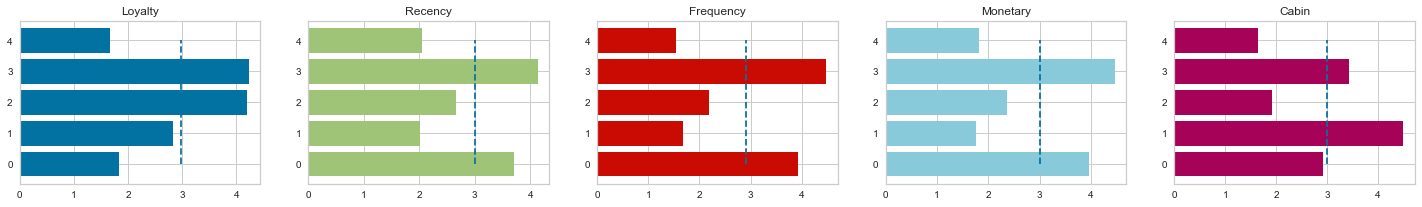

In [156]:
LRFMC=['Loyalty','Recency','Frequency','Monetary','Cabin']

def dist_list(lst):
    plt.figure(figsize=[len(lst)*5,3])
    i = 1
    cl = ['bgrcmykw'[c] for c in range(len('bgrcmykw'))]
    for col in lst:
        ax = plt.subplot(1,len(lst),i)
        ax.vlines(feature[col].mean(), ymin=0, ymax=4, color='b', linestyle='--')
        g = feature.groupby('cluster')
        x = g[col].mean().index
        y = g[col].mean().values
        ax.barh(x,y,color=cl[i-1])
        plt.title(col)
        i = i+1
    plt.savefig(f'avglrfmc_cluster.png')
        
dist_list(LRFMC)

* `Cluster 0` : L &darr; R &uarr; F &uarr; M &uarr; C &darr;

* `Cluster 1` : L &darr; R &darr; F &darr; M &darr; C &uarr; 

* `Cluster 2` : L &uarr; R &darr; F &darr; M &darr; C &darr;

* `Cluster 3` : L &uarr; R &uarr; F &uarr; M &uarr; C &uarr;

* `Cluster 4` : L &darr; R &darr; F &darr; M &darr; C &darr;

### 4.3.3. Radar Chart for Each Cluster

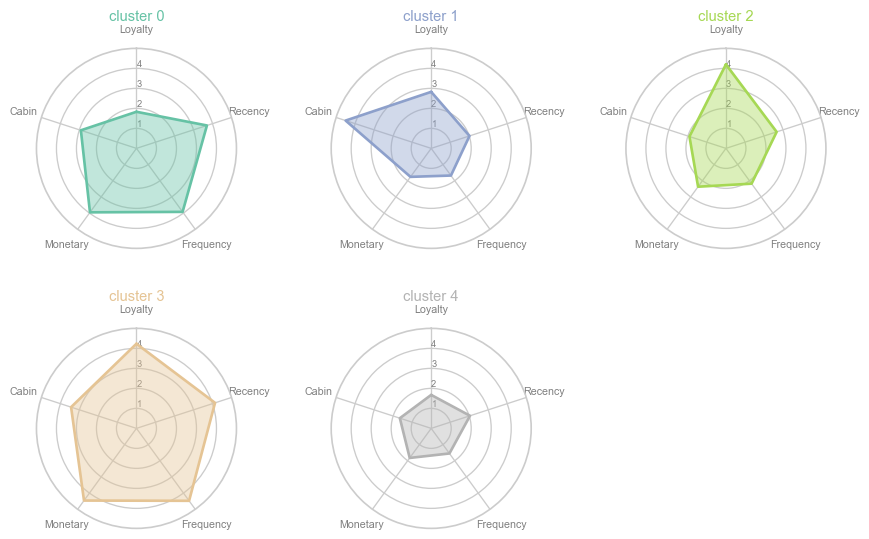

In [158]:
from math import pi
 
# ------- PART 1: Define a function that do a plot for one line of the dataset!
 
def make_spider( row, title, color):
    # number of variable
    categories = list(centroid_df)[1:]
    N = len(categories)
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    # Initialise the spider plot
    ax = plt.subplot(2,3,row+1, polar=True, )
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([1,2,3,4], ["1","2","3","4"], color="grey", size=7)
    plt.ylim(0,5)

    # Ind1
    values=centroid_df.loc[row].drop(['cluster']).values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)
    # Add a title
    plt.title(title, size=11, color=color, y=1.1)
    #plt.tight_layout()
    plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

# ------- PART 2: Apply the function to all individuals
# initialize the figure
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 600/my_dpi), dpi=my_dpi) 
# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(centroid_df.index))
 
# Loop to plot
for row in range(0, len(centroid_df.index)):
    make_spider( row=row, title='cluster '+str(centroid_df['cluster'][row]), color=my_palette(row))
    plt.savefig(f'cluster{row}_profile.png')

`Consumption` : **High** Cluster 0 and 3 **Low** Cluster 1, 2, and 4

`Recency` : **High** Cluster 0 and 3 **Average** Cluster 2  **Low** Cluster 1, and 4

`Loyalty` : **High** Cluster 2 and 3 **Average** Cluster 1 **Low** Cluster 0 and 4

`Class (Cabin)` : **High** Cluster 1 and 3 **Average** Cluster 0 **Low** Cluster 2 and 4

### 4.4. Clustering Analysis (Behavioural Segmentation)

After modelling and visualization we have done before, here we try to describe the behaviour from each cluster based on LRFMC model and rank them based on their value towards our product and service. 

1. Cluster 3 (**Loyalist/High Value**): Most valuable, core customers. Long-term customer with high consumption due to frequent purchase and longer distance, loyal, often fly with higher class of cabin.


2. Cluster 0 (**Potential Loyalist/High Prospect**): New member with high consumption due to frequent purchase and longer distance. Fresh, near from the latest purchase and often sit in standard class of cabin.


3. Cluster 2 (**Low Consumer**): Long term customer but low consumption, occasional traveler and shorter distance (less purchase). Not so far from the latest purchase and often book for low class of cabin.


4. Cluster 1 (**Hibernating VIP/ Can't Lose Them**): Have been with us in a medium term but low consumption due to infrequent purchase and shorter distance. Haven't purchased our service lately, but often book for higher class of cabin.


5. Cluster 4 (**Uncertain Lost/Low Value**): New member with very low consumption, rare purchase and shorter distance. Haven't used our service lately and used to book for low class of cabin.

## 5. Conclusion and Recommendation

Segmentation helps us to be more efficient in terms of time, money and other resources. Customer segmentation allows us to learn about our customers. We can gain a better understanding of customer's behaviour and therefore can tailor campaigns to customer segments most likely to purchase our products.

Here we use K-Means, the most popular clustering machine learning algorithm to portray each customer group best. We refer to LRFMC model, emphasizing the behavioural aspect of customers on Loyalty (relation length), Recency (latest purchase), Frequency (purchase frequency), Monetary (purchase value), and Cabin (purchase level/flight class). 

### 5.1. Conclusion

* 91.71% customers come from China, followed by their neighbourhood: Hong Kong, South Korea, and Japan.
* Most customers are Male, takes up 76.5%
* There are three tiers of FFP (Frequent Flyer Program) offered: 4 - 6 tier. 92.1% customers hold tier 4 FFP.
* The core customers aged 35-45 years old
* There are 5 customer segments (rank from left to right): Loyalist - High Prospect - Low Consumer - Hibernating VIP - Uncertain Lost.
* Based on the total customer proportion, 
    * High value customer takes up around 55%
    * Loyal customer takes up 40%, in the contrary 60% are relatively new member.

### 5.2. Recommendation

Here we try to offer some recommendation on the approach tailored to each customer segments.

1. **Loyalist/High Value Customer** (Cluster 3): Most valuable and core customers. We should maintain the relationship and reward these customers by giving extra discount or free ticket, chance to win prize of flight to popular destination, and special souvenirs. We can also give them early access for our newest product/service and approach them to affiliate our product to help our promotion.


2. **Potential Loyalist/High Prospect Customer** (Cluster 0): New member with very high consumption. We should retend these customers as long as possible. We can offer extra discount or free ticket after some period or of membership or mileage. Offer them discount or extra points that could be redeemed to upgrade for higher class of cabin to give them experience. 


3. **Low Consumer** (Cluster 2): Old customer but low consumption. We should encourage them to purchase more by providing special offers such as discount for longer distance flight and reward them as a regular customer by giving free voucher for affiliated product/event after achieving some flight records in some period, for example 2 flights in a year. 


4. **Hibernating VIP/ Can't Lose Them** (Cluster 1): Recently absent higher class passenger. We should attract them to buy our product again. Assuming this type of customer comes from higher class, bring them back with flight promotions that is bundled with destination event vouchers or signatured souvenirs. Run surveys to find out what went wrong and avoid losing them to a competitor.


5. **Uncertain Lost/Low Value Customer** (Cluster 4): New member with very low consumption. Send them personalized campaigns/promo to reconnect and notify discount and helpful products to encourage another purchase.

Apart from the customer approach recommendation, there are some suggestion to optimize the clustering result:

* Evaluate the clustering result with ANOVA or other testing methods.
* Implement multiple robust hyperparameter tuning methods to validate the best number of cluster.
* Combine this behavioural aspect based customer categorization with demographic and geographic aspect.

### Reference

[1] Tao, Y.: Analysis Method for Customer Value of Aviation Big Data Based on LFRMC Model. ICPCSEE 2020, CCIS 1257. 89-100(2020)

[2] Kandeil, D., Saad, A. and Youssef, S. M.: A Two-phase Clustering Analysis for B2B Customer Segmentation. INCoS 2014, IEEE. 221-228(2014)

[3] Wer, J. T., et. al: Applying Data Mining and RFM Model to Analyze Customers’ Values of A Veterinary Hospital. IS3C 2016, IEEE, 481-484(2016)

[4] https://www.kaggle.com/code/gilangpanduparase/air-line-customer-segmentation/notebook?scriptVersionId=64809717

[5] https://clevertap.com/blog/rfm-analysis/

[6] https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad

[7] https://github.com/mrafifrbbn/airline_customer_segmentation/blob/main/Airline%20Customer%20Segmentation.ipynb